In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid',font_scale=1.5)
pd.set_option('display.max.rows',None)
pd.set_option('display.max.columns',None)


In [2]:
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier,StackingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier


In [3]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder,MinMaxScaler,OneHotEncoder,StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score,confusion_matrix
from imblearn.over_sampling import SMOTE


In [4]:
train=pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
test=pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')

In [5]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [7]:
train.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [8]:
cat=train.select_dtypes('object').columns

In [9]:
print(*cat,sep=',')


PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name


In [10]:
num=train.select_dtypes('number').columns

In [11]:
print(*num,sep=',')

Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck


# Checking the duplicacy

In [12]:
print(f'Duplicates in training dataset are: {train.duplicated().sum()}')
print(f'Duplicates in test dataset are: {test.duplicated().sum()}')
    

Duplicates in training dataset are: 0
Duplicates in test dataset are: 0


# Missing Values

In [13]:
df1=(train.isnull().sum()[train.isnull().sum()>0]).to_frame().rename(columns={0:'Number of Missing values in training dataset'})
df1['Percentage of missing values']=round((100*train.isnull().sum()[train.isnull().sum()>0]/len(train)),2)
df1

,Number of Missing values in training dataset,Percentage of missing values
HomePlanet,201,2.31
CryoSleep,217,2.50
Cabin,199,2.29
Destination,182,2.09
Age,179,2.06
VIP,203,2.34
RoomService,181,2.08
FoodCourt,183,2.11
ShoppingMall,208,2.39
Spa,183,2.11


Thus we dont need to drop any values

In [14]:
df2=(test.isnull().sum()[test.isnull().sum()>0]).to_frame().rename(columns={0:"Missing values in test data"})
df2['Percentage']=round((100*test.isnull().sum()[test.isnull().sum()>0]/len(test)),2).values
df2

,Missing values in test data,Percentage
HomePlanet,87,2.03
CryoSleep,93,2.17
Cabin,100,2.34
Destination,92,2.15
Age,91,2.13
VIP,93,2.17
RoomService,82,1.92
FoodCourt,106,2.48
ShoppingMall,98,2.29
Spa,101,2.36


In [15]:
print("Cardinality of the training dataset")
print(train.select_dtypes(include='object').nunique())
print('-'*70)
print('Cardinality of the testing dataset')
print(test.select_dtypes(include='object').nunique())

Cardinality of the training dataset
PassengerId    8693
HomePlanet        3
CryoSleep         2
Cabin          6560
Destination       3
VIP               2
Name           8473
dtype: int64
----------------------------------------------------------------------
Cardinality of the testing dataset
PassengerId    4277
HomePlanet        3
CryoSleep         2
Cabin          3265
Destination       3
VIP               2
Name           4176
dtype: int64


# Exponential data analysis

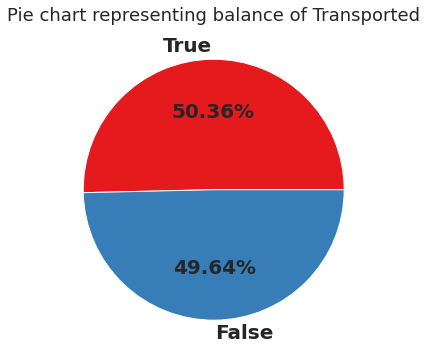

In [16]:
plt.figure(figsize=(10,6))
plt.pie(train['Transported'].value_counts(),labels=train['Transported'].value_counts().keys(),autopct='%1.2f%%', 
textprops={'fontsize':20,'fontweight':'black'},colors=sns.color_palette('Set1'))
plt.title('Pie chart representing balance of Transported');

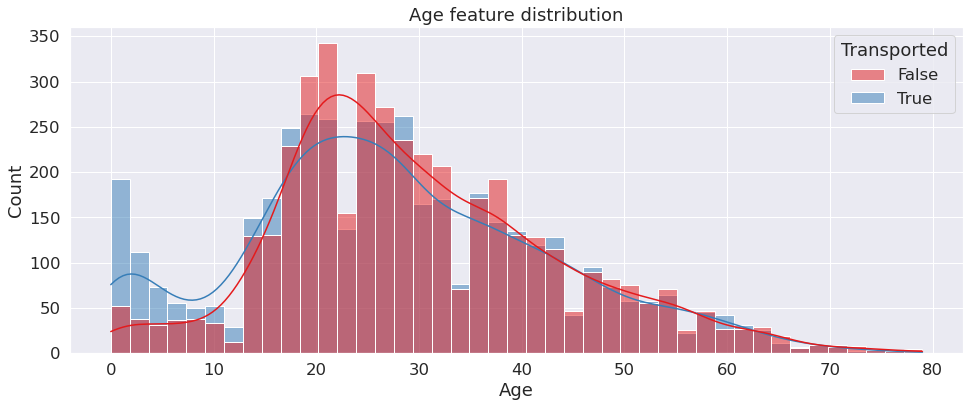

In [17]:
plt.figure(figsize=(16,6))
sns.histplot(x=train['Age'],hue='Transported',data=train,kde=True,palette='Set1')
plt.title('Age feature distribution');

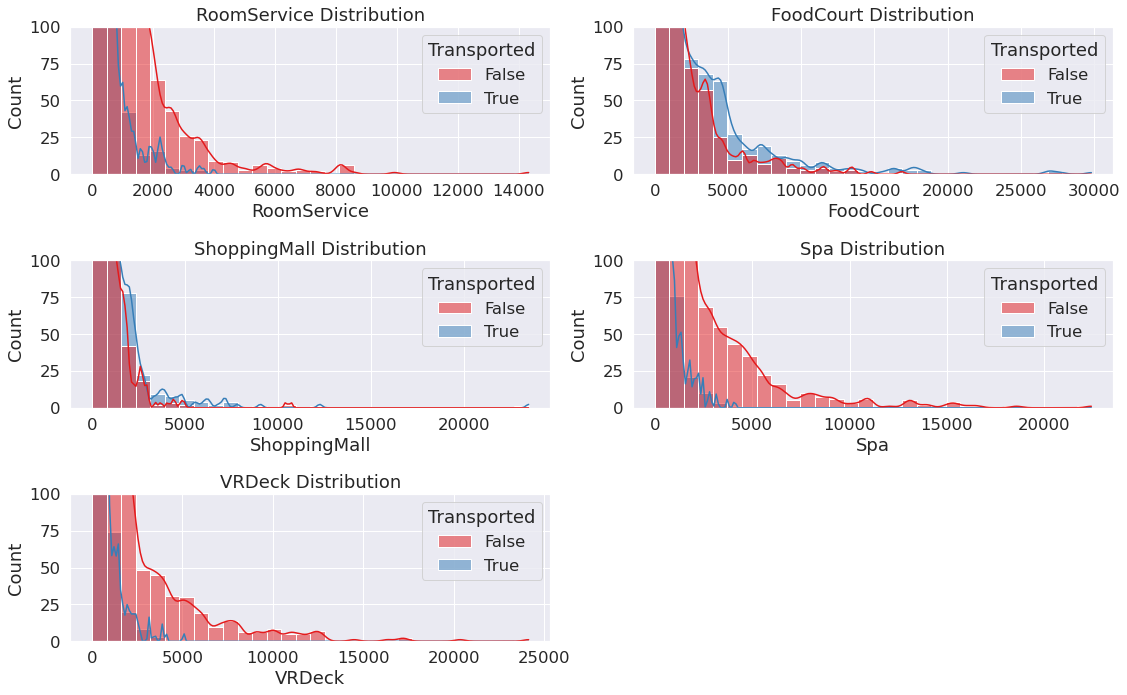

In [18]:
expenditure_cols=['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
plt.figure(figsize=(16,10))
for idx,col in enumerate(expenditure_cols):
    plt.subplot(3,2,idx+1)
    sns.histplot(x=col,hue='Transported',data=train,bins=30,kde=True,palette='Set1')
    plt.title(f'{col} Distribution')
    plt.ylim(0,100)
    plt.tight_layout()
    
    

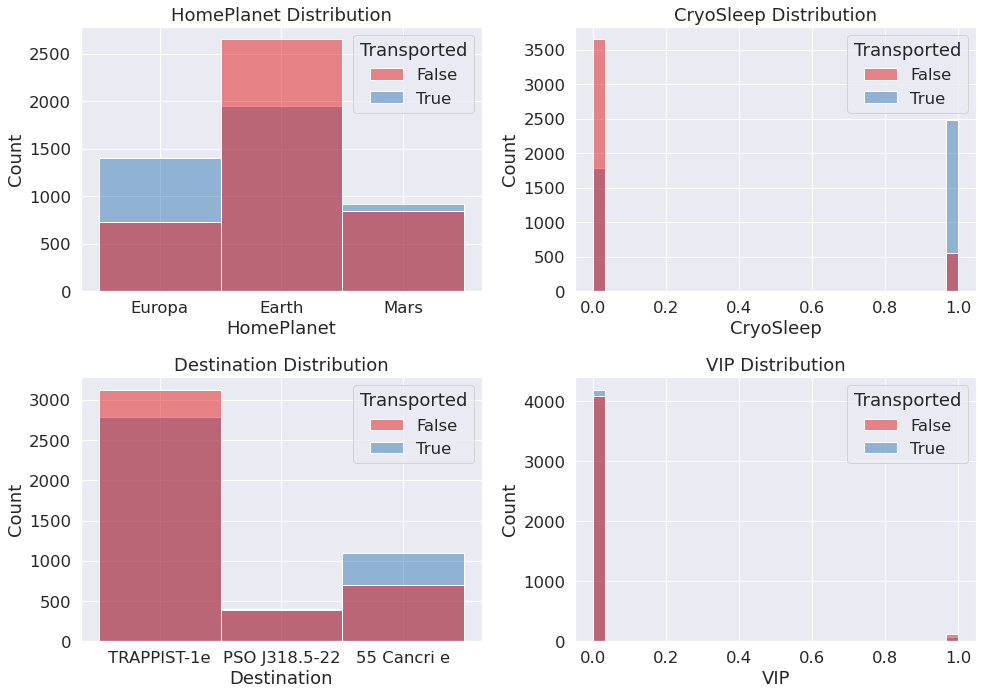

In [19]:
cat_cols=['HomePlanet','CryoSleep','Destination','VIP']
plt.figure(figsize=(14,10))
for idx,col in enumerate(cat_cols):
    plt.subplot(2,2,idx+1)
    sns.histplot(x=col,hue='Transported',data=train,bins=30,palette='Set1')
    plt.title(f'{col} Distribution')
    plt.tight_layout()


# Feature Engineering

In [20]:
train['PassengerId'].head().to_frame()

,PassengerId
0,0001_01
1,0002_01
2,0003_01
3,0003_02
4,0004_01


In [21]:
def passenger_new_features(df):
    df['Group']=df['PassengerId'].apply(lambda x:x.split('_')[0])
    df['Member']=df['PassengerId'].apply(lambda x:x.split('_')[1])
    x=df.groupby('Group')['Member'].count().sort_values()
    y=set(x[x>1].index)
    df['Travelling_Solo']=df['Group'].apply(lambda x:x not in y)
    df['Group_Size']=0
    for i in x.items():
        df.loc[df['Group']==i[0],'Group_Size']=i[1]

In [22]:
passenger_new_features(train)
passenger_new_features(test)

In [23]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group,Member,Travelling_Solo,Group_Size
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0001,01,True,1
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0002,01,True,1
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0003,01,False,2
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,0003,02,False,2
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,0004,01,True,1


In [24]:
train.drop(columns=['Group','Member'],inplace=True)
test.drop(columns=['Group','Member'],inplace=True)

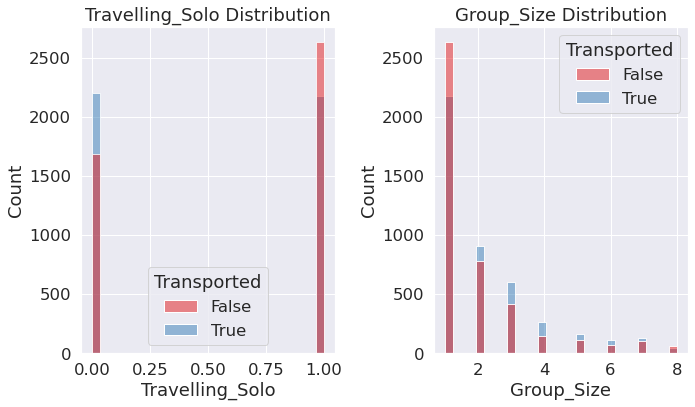

In [25]:
features=['Travelling_Solo','Group_Size']
plt.figure(figsize=(10,6))
for idx,col in enumerate(features):
    plt.subplot(1,2,idx+1)
    sns.histplot(x=col,hue='Transported',bins=30,data=train,palette='Set1')
    plt.title(f'{col} Distribution')
    plt.tight_layout()


In [26]:
train['Cabin'].head().to_frame()

,Cabin
0,B/0/P
1,F/0/S
2,A/0/S
3,A/0/S
4,F/1/S


In [27]:
def cabin_new_features(df):
    df['Cabin'].fillna('np.nan/np.nan/np.nan',inplace=True)
    df['Cabin_Deck']=df['Cabin'].apply(lambda x:x.split('/')[0])
    df['Cabin_Number']=df['Cabin'].apply(lambda x:x.split('/')[1])
    df['Cabin_Side']=df['Cabin'].apply(lambda x:x.split('/')[2])
    cols=['Cabin_Deck','Cabin_Number','Cabin_Side']
    df[cols]=df[cols].replace('np.nan',np.nan)
    df['Cabin_Deck'].fillna(df['Cabin_Deck'].mode()[0],inplace=True)
    df['Cabin_Side'].fillna(df['Cabin_Number'].mode()[0],inplace=True)
    df['Cabin_Number'].fillna(df['Cabin_Number'].median(),inplace=True)

    

In [28]:
cabin_new_features(test)
cabin_new_features(train)

In [29]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Travelling_Solo,Group_Size,Cabin_Deck,Cabin_Number,Cabin_Side
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,True,1,B,0,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,True,1,F,0,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,False,2,A,0,S
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,False,2,A,0,S
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,True,1,F,1,S


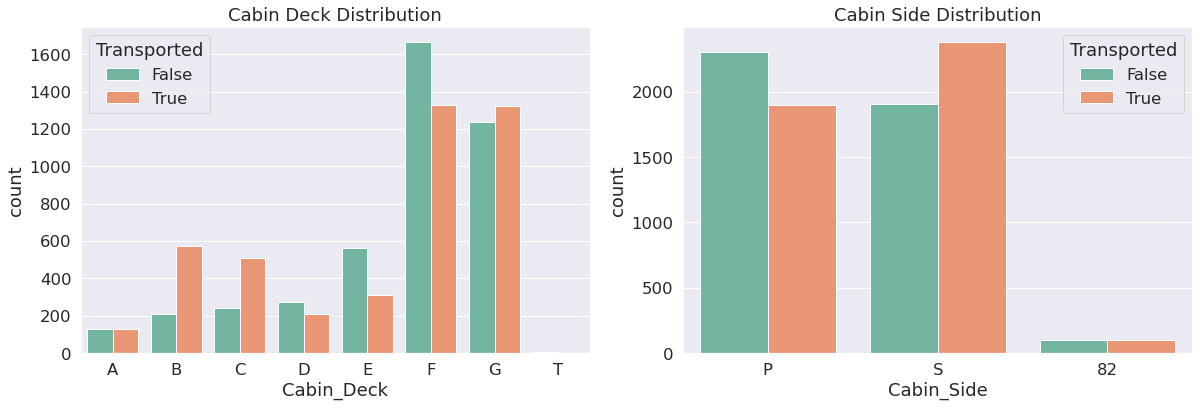

In [30]:
plt.figure(figsize=(17,6))
plt.subplot(1,2,1)
sns.countplot(x='Cabin_Deck',hue='Transported',data=train,order=['A','B','C','D','E','F','G','T'],palette=
             'Set2')
plt.title('Cabin Deck Distribution')
plt.subplot(1,2,2)
sns.countplot(x='Cabin_Side',hue='Transported',data=train,palette='Set2')
plt.title('Cabin Side Distribution')
plt.tight_layout()
plt.show()

In [31]:
train['Cabin_Number']=train['Cabin_Number'].astype(int)
test['Cabin_Number']=test['Cabin_Number'].astype(int)

In [32]:
print('The total number of unique values in the cabin number is: ',train['Cabin_Number'].nunique())
print('The mean of the cabin number feature is: ',train.Cabin_Number.mean())
print('The median of the cabin number feature is: ',train.Cabin_Number.median())

The total number of unique values in the cabin number is:  1817
The mean of the cabin number feature is:  596.3989416772115
The median of the cabin number feature is:  427.0


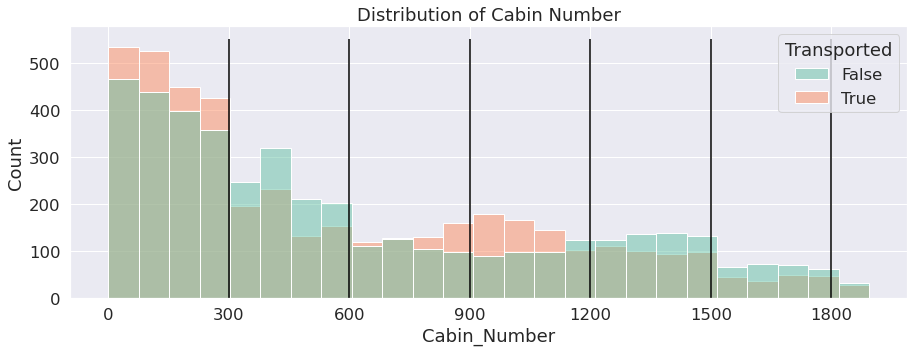

In [33]:
plt.figure(figsize=(15,5))
sns.histplot(x='Cabin_Number',hue='Transported',data=train,palette='Set2')
plt.xticks(list(range(0,1900,300)))
plt.title('Distribution of Cabin Number')
plt.vlines(300,ymin=0,ymax=550,color='black')
plt.vlines(600,ymin=0,ymax=550,color='black')
plt.vlines(900,ymin=0,ymax=550,color='black')
plt.vlines(1200,ymin=0,ymax=550,color='black')
plt.vlines(1500,ymin=0,ymax=550,color='black')
plt.vlines(1800,ymin=0,ymax=550,color='black')
plt.show()

In [34]:
def cabin_regions(df):
    df['Cabin_region1']=(df['Cabin_Number']<300)
    df['Cabin_region2']=(df['Cabin_Number']>=300) & (df['Cabin_Number']<600)
    df['Cabin_region3']=(df['Cabin_Number']>=600) & (df['Cabin_Number']<900)
    df['Cabin_region4']=(df['Cabin_Number']>=900) & (df['Cabin_Number']<1200)
    df['Cabin_region5']=(df['Cabin_Number']>=1200) & (df['Cabin_Number']<1500)
    df['Cabin_region6']=(df['Cabin_Number']>=1500)

In [35]:
cabin_regions(train)
cabin_regions(test)

In [36]:
# todel=['Cabin_Region1','Cabin_Region2','Cabin_Region3','Cabin_Region4','Cabin_Region5','Cabin_Region6']
# for i in todel:
#     train.drop(i,axis=1,inplace=True)
#     test.drop(i,axis=1,inplace=True)

In [37]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Travelling_Solo,Group_Size,Cabin_Deck,Cabin_Number,Cabin_Side,Cabin_region1,Cabin_region2,Cabin_region3,Cabin_region4,Cabin_region5,Cabin_region6
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,True,1,B,0,P,True,False,False,False,False,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,True,1,F,0,S,True,False,False,False,False,False
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,False,2,A,0,S,True,False,False,False,False,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,False,2,A,0,S,True,False,False,False,False,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,True,1,F,1,S,True,False,False,False,False,False


In [38]:
train.drop(columns=["Cabin_Number"],inplace=True)
test.drop(columns=["Cabin_Number"],inplace=True)

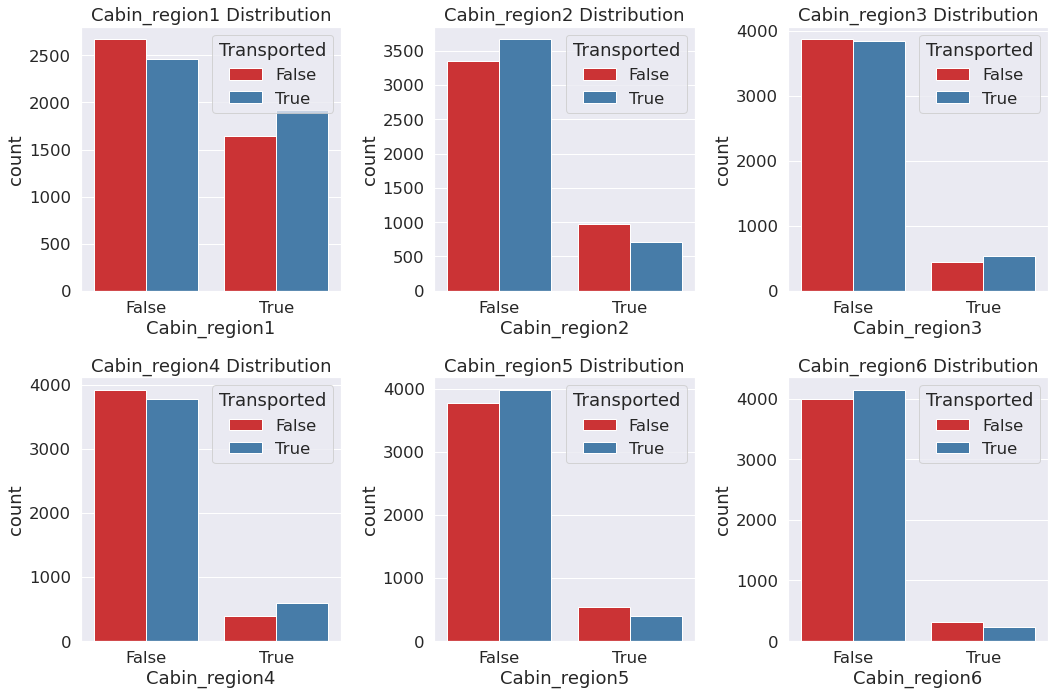

In [39]:
cols=['Cabin_region1','Cabin_region2','Cabin_region3','Cabin_region4','Cabin_region5','Cabin_region6']
plt.figure(figsize=(15,10))
for i,j in enumerate(cols):
    plt.subplot(2,3,i+1)
    sns.countplot(x=j,hue='Transported',data=train,palette='Set1')
    plt.title(f'{j} Distribution')
    plt.tight_layout()
    

# Creating features from Age

In [40]:
train['Age'].head().to_frame()

,Age
0,39.0
1,24.0
2,58.0
3,33.0
4,16.0


In [41]:
def age_group(df):
    age_group=[]
    for i in df['Age']:
        if i<=12:
            age_group.append('Age_0-12')
        elif (i>12 and i<=18):
            age_group.append('Age_13-18')
        elif (i>18 and i<=25):
            age_group.append('Age_19-25')
        elif (i>25 and i<=32):
            age_group.append('Age_26-32')
        elif (i>32  and i<=50):
            age_group.append('Age_32-50')
        elif i>50:
            age_group.append('Age_50+')
        else:
            age_group.append(np.nan)
    df['Age_Group']=age_group

In [42]:
age_group(train)
age_group(test)

In [43]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Travelling_Solo,Group_Size,Cabin_Deck,Cabin_Side,Cabin_region1,Cabin_region2,Cabin_region3,Cabin_region4,Cabin_region5,Cabin_region6,Age_Group
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,True,1,B,P,True,False,False,False,False,False,Age_32-50
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,True,1,F,S,True,False,False,False,False,False,Age_19-25
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,False,2,A,S,True,False,False,False,False,False,Age_50+
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,False,2,A,S,True,False,False,False,False,False,Age_32-50
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,True,1,F,S,True,False,False,False,False,False,Age_13-18


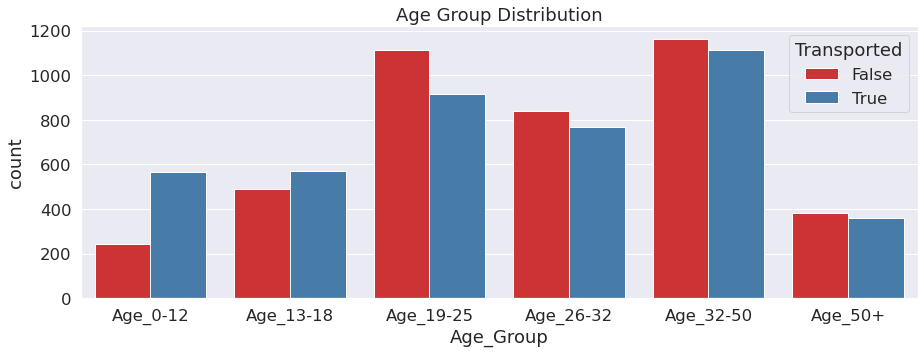

In [44]:
order=sorted(train['Age_Group'].value_counts().keys().to_list())
plt.figure(figsize=(15,5))
sns.countplot(x='Age_Group',hue='Transported',data=train,palette='Set1',order=order)
plt.title('Age Group Distribution')
plt.show()

In [45]:
train[['RoomService','FoodCourt','ShoppingMall','VRDeck']].head()

,RoomService,FoodCourt,ShoppingMall,VRDeck
0,0.0,0.0,0.0,0.0
1,109.0,9.0,25.0,44.0
2,43.0,3576.0,0.0,49.0
3,0.0,1283.0,371.0,193.0
4,303.0,70.0,151.0,2.0


In [46]:
exp_cols=['RoomService','FoodCourt','ShoppingMall','VRDeck']
def new_features(df):
    df['Total_Expenditure']=df[exp_cols].sum(axis=1)
    df['No_Expenditure']=(df['Total_Expenditure']==0)

In [47]:
new_features(train)
new_features(test)

(0.0, 10000.0)

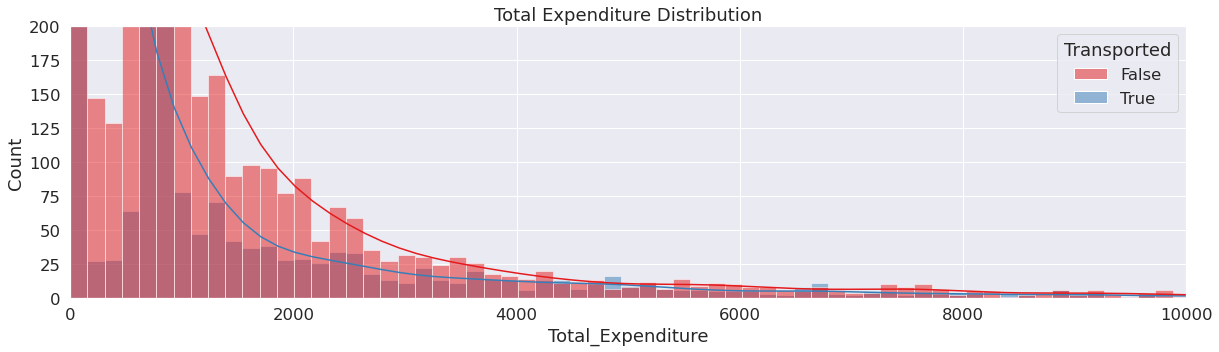

In [48]:
plt.figure(figsize=(20,5))
sns.histplot(x='Total_Expenditure',hue='Transported',data=train,palette='Set1',kde=True,bins=200)
plt.title('Total Expenditure Distribution')
plt.ylim(0,200)
plt.xlim(0,10000)

In [49]:
mean=round(train.Total_Expenditure.mean())
median=round(train.Total_Expenditure.median())
print('The mean of the total expenditure is: ',mean)
print('The median of the total expenditure is: ',median)

The mean of the total expenditure is:  1136
The median of the total expenditure is:  408


In [50]:
def expenditure_category(df):
    expenseCat=[]
    for i in df['Total_Expenditure']:
        if i==0:
            expenseCat.append('NoExpense')
        if (i>0) & (i<=408):
            expenseCat.append('Low_Expense')
        if (i>408) & (i<=1136):
            expenseCat.append('Medium_Expense')
        if (i>1136):
            expenseCat.append('High_Expense')
    df['Expenditure_Category']=expenseCat

In [51]:
expenditure_category(train)
expenditure_category(test)

In [52]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Travelling_Solo,Group_Size,Cabin_Deck,Cabin_Side,Cabin_region1,Cabin_region2,Cabin_region3,Cabin_region4,Cabin_region5,Cabin_region6,Age_Group,Total_Expenditure,No_Expenditure,Expenditure_Category
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,True,1,B,P,True,False,False,False,False,False,Age_32-50,0.0,True,NoExpense
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,True,1,F,S,True,False,False,False,False,False,Age_19-25,187.0,False,Low_Expense
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,False,2,A,S,True,False,False,False,False,False,Age_50+,3668.0,False,High_Expense
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,False,2,A,S,True,False,False,False,False,False,Age_32-50,1847.0,False,High_Expense
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,True,1,F,S,True,False,False,False,False,False,Age_13-18,526.0,False,Medium_Expense


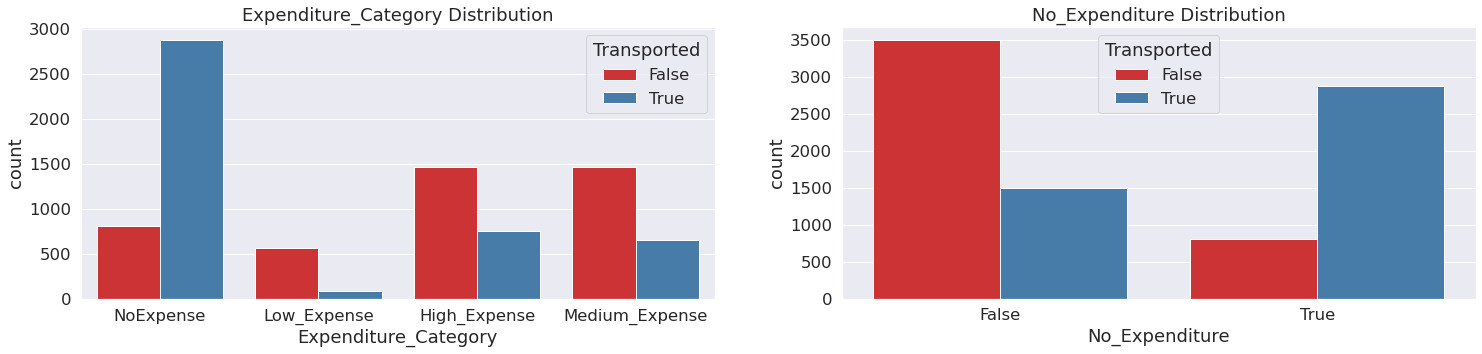

In [53]:
cols=['Expenditure_Category','No_Expenditure']
plt.figure(figsize=(25,5))
for i,j in enumerate(cols):
    plt.subplot(1,2,i+1)
    sns.countplot(x=j,hue='Transported',data=train,palette='Set1')
    plt.title(f'{j} Distribution')

# Data Preprocessing

In [54]:
z=train.isnull().sum()[train.isnull().sum()>0].to_frame().rename(columns={0:'No. of Missing Values'})
z['% of null values']=round(train.isnull().sum()[train.isnull().sum()>0]*100/len(train),2)

In [55]:
z

,No. of Missing Values,% of null values
HomePlanet,201,2.31
CryoSleep,217,2.50
Destination,182,2.09
Age,179,2.06
VIP,203,2.34
RoomService,181,2.08
FoodCourt,183,2.11
ShoppingMall,208,2.39
Spa,183,2.11
VRDeck,188,2.16


In [56]:
import missingno as msno

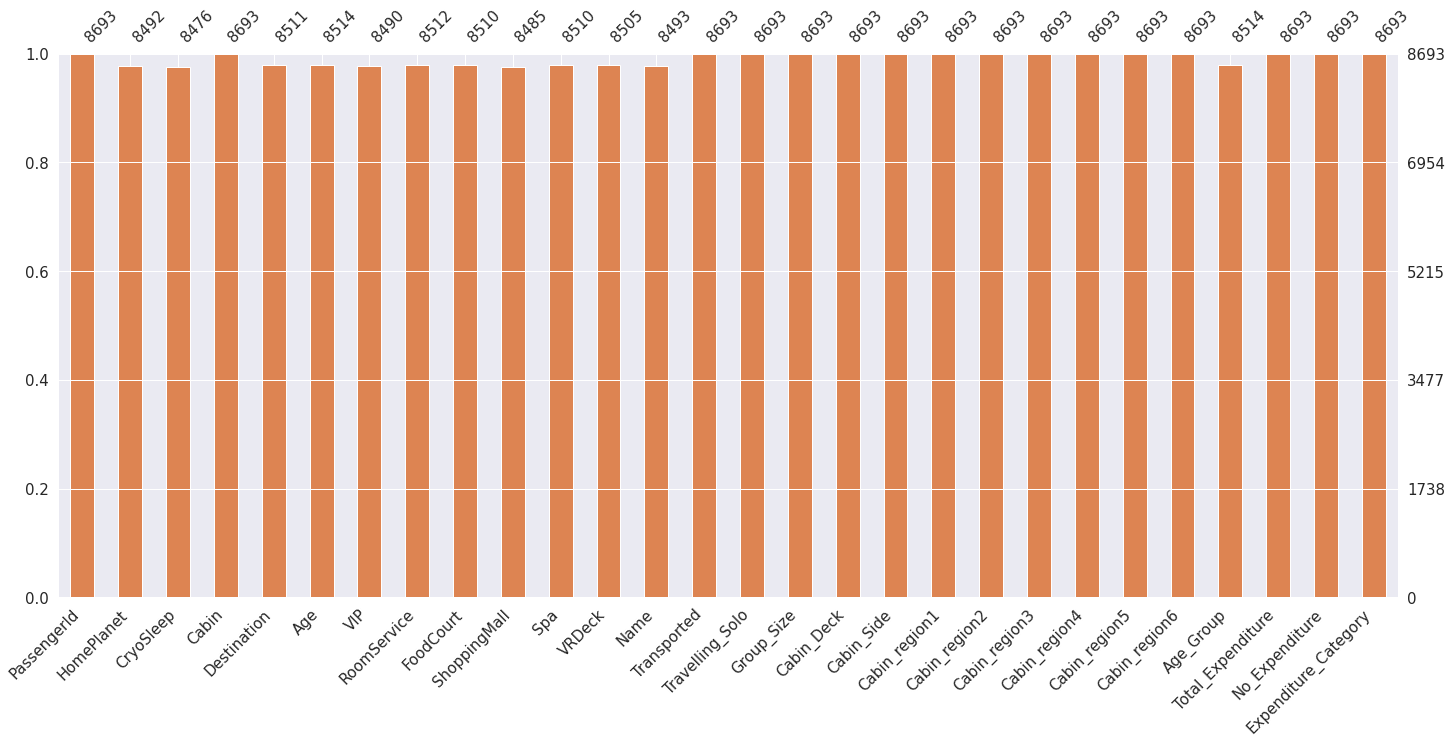

In [57]:
msno.bar(train,color='C1',fontsize=15)
plt.show()

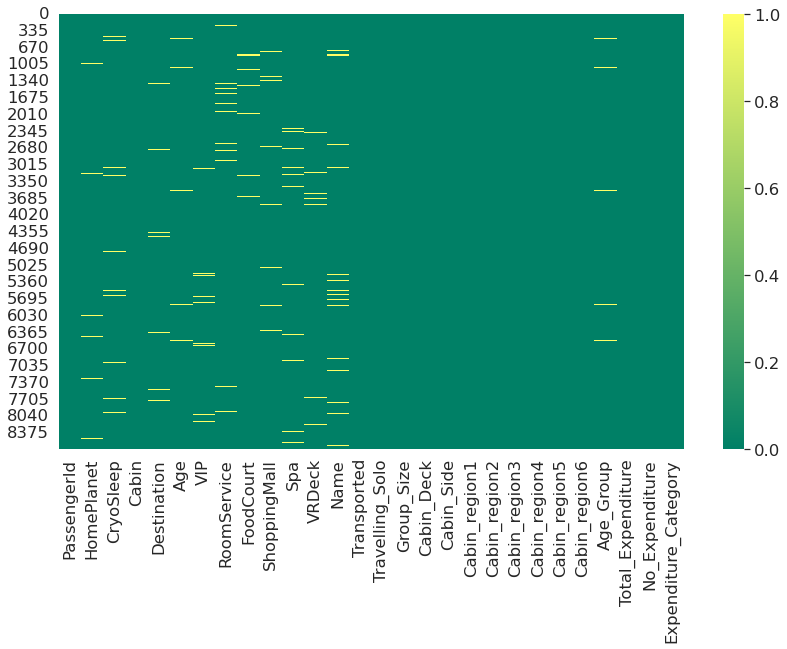

In [58]:
plt.figure(figsize=(14,8))
sns.heatmap(train.isnull(),cmap='summer')
plt.show()

In [59]:
cat_cols=train.select_dtypes(include=['object','bool']).columns.tolist()
cat_cols.remove('Transported')
nums_cols=train.select_dtypes(include=['int','float']).columns.tolist()

In [60]:
print(cat_cols)
print('-'*210)
print(nums_cols)

['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP', 'Name', 'Travelling_Solo', 'Cabin_Deck', 'Cabin_Side', 'Cabin_region1', 'Cabin_region2', 'Cabin_region3', 'Cabin_region4', 'Cabin_region5', 'Cabin_region6', 'Age_Group', 'No_Expenditure', 'Expenditure_Category']
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Group_Size', 'Total_Expenditure']


In [61]:
imputer1=SimpleImputer(strategy='most_frequent')
imputer2=SimpleImputer(strategy='median')

In [62]:
def fillvalue(df):
    df[cat_cols]=imputer1.fit_transform(df[cat_cols])
    df[nums_cols]=imputer2.fit_transform(df[nums_cols]) 


In [63]:
fillvalue(train)
fillvalue(test)

In [64]:
train.isnull().sum().sum()

0

In [65]:
print(train.duplicated().sum())
print(test.duplicated().sum())

0
0


In [66]:
print(train.select_dtypes(include=['object']).nunique())
print('-'*210)
print(test.select_dtypes(include=['object']).nunique())

PassengerId             8693
HomePlanet                 3
CryoSleep                  2
Cabin                   6561
Destination                3
VIP                        2
Name                    8473
Travelling_Solo            2
Cabin_Deck                 8
Cabin_Side                 3
Cabin_region1              2
Cabin_region2              2
Cabin_region3              2
Cabin_region4              2
Cabin_region5              2
Cabin_region6              2
Age_Group                  6
No_Expenditure             2
Expenditure_Category       4
dtype: int64
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
PassengerId             4277
HomePlanet                 3
CryoSleep                  2
Cabin                   3266
Destination                3
VIP                        2
Name                    4176
Travelling_Solo       

In [67]:
passenger_df=test['PassengerId']

In [68]:
cols=['PassengerId','Cabin','Name']
for i in cols:
    train.drop(columns=i,inplace=True)
    test.drop(columns=i,inplace=True)
    

In [69]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,8693.0,28.790291,14.341404,0.0,20.0,27.0,37.0,79.0
RoomService,8693.0,220.009318,660.519050,0.0,0.0,0.0,41.0,14327.0
FoodCourt,8693.0,448.434027,1595.790627,0.0,0.0,0.0,61.0,29813.0
ShoppingMall,8693.0,169.572300,598.007164,0.0,0.0,0.0,22.0,23492.0
Spa,8693.0,304.588865,1125.562559,0.0,0.0,0.0,53.0,22408.0
VRDeck,8693.0,298.261820,1134.126417,0.0,0.0,0.0,40.0,24133.0
Group_Size,8693.0,2.035546,1.596347,1.0,1.0,1.0,3.0,8.0
Total_Expenditure,8693.0,1136.277465,2320.407442,0.0,0.0,408.0,1170.0,30872.0


In [70]:
cols=['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','Total_Expenditure']
for val in cols:
    train[val]=np.log(1+train[val])
    test[val]=np.log(1+test[val])

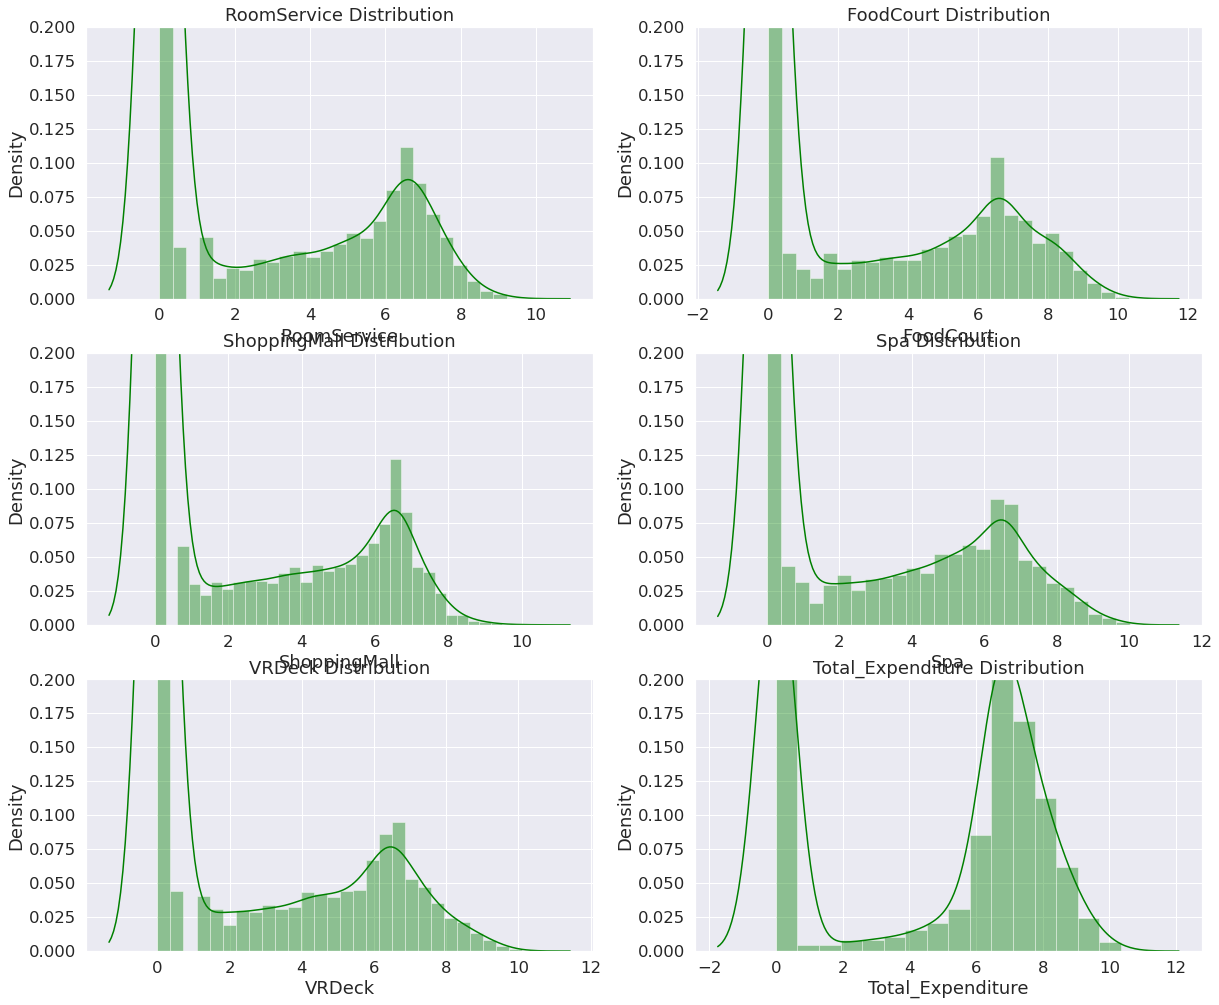

In [71]:
plt.figure(figsize=(20,35))
for j,i in enumerate(cols):
    plt.subplot(6,2,j+1)
    sns.distplot(train[i],color='green')
    plt.ylim(0,0.2)
    plt.title(f'{i} Distribution')


In [72]:
train.dtypes

HomePlanet               object
CryoSleep                object
Destination              object
Age                     float64
VIP                      object
RoomService             float64
FoodCourt               float64
ShoppingMall            float64
Spa                     float64
VRDeck                  float64
Transported                bool
Travelling_Solo          object
Group_Size              float64
Cabin_Deck               object
Cabin_Side               object
Cabin_region1            object
Cabin_region2            object
Cabin_region3            object
Cabin_region4            object
Cabin_region5            object
Cabin_region6            object
Age_Group                object
Total_Expenditure       float64
No_Expenditure           object
Expenditure_Category     object
dtype: object

In [73]:
cols=['CryoSleep','VIP','Travelling_Solo','No_Expenditure','Cabin_region1','Cabin_region2','Cabin_region3','Cabin_region4','Cabin_region5','Cabin_region6']
train[cols]=train[cols].astype(bool)
test[cols]=test[cols].astype(bool)

In [74]:
nominal_cat_cols=['HomePlanet','Destination']
ordinal_cat_cols=['CryoSleep','VIP','Travelling_Solo','Cabin_Deck','Cabin_Side','Cabin_region1','Cabin_region2','Cabin_region3','Cabin_region4','Cabin_region5','Cabin_region6','Age_Group','No_Expenditure','Expenditure_Category']


In [75]:
enc=LabelEncoder()


In [76]:
train[ordinal_cat_cols]=train[ordinal_cat_cols].apply(enc.fit_transform)
test[ordinal_cat_cols]=train[ordinal_cat_cols].apply(enc.fit_transform)

In [77]:
train=pd.get_dummies(train,columns=nominal_cat_cols)


In [78]:
test=pd.get_dummies(test,columns=nominal_cat_cols)

In [79]:
train['Transported'].replace({False:0,True:1},inplace=True)

In [80]:
X=train.drop(columns='Transported')
y=train['Transported']

In [81]:
scaler=StandardScaler()

In [82]:
X_scaled=scaler.fit_transform(X)
test_scaled=scaler.fit_transform(test)

In [83]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [84]:
print(X_train.shape,X_test.shape)

(6954, 28) (1739, 28)


In [85]:
X_train1,X_test1,y_train1,y_test1=train_test_split(X_scaled,y,test_size=0.2,random_state=1)

# Model Building

In [86]:
training_score=[]
test_score=[]

In [87]:
def model_prediction(model):
    model.fit(X_train1,y_train1)
    X_train_pred1=model.predict(X_train1)
    X_test_pred1=model.predict(X_test1)
    a=accuracy_score(y_train1,X_train_pred1)*100
    b=accuracy_score(y_test1,X_test_pred1)*100
    training_score.append(a)
    test_score.append(b)
    print(f'The training Accuracy score of the {model} is: {a}')
    print(f'The test Accuracy score of the {model} is: {b} ')
    print(f'The precision score of the {model} is: ',precision_score(y_test1,X_test_pred1))
    print(f'The recall score of the {model} is: ',recall_score(y_test1,X_test_pred1))
    print(f'The F1 score of the {model} is: ',f1_score(y_test1,X_test_pred1))
    cm=confusion_matrix(y_test1,X_test_pred1)
    plt.figure(figsize=(8,4))
    sns.heatmap(cm,annot=True,fmt='g',cmap='summer')
    plt.show()

The training Accuracy score of the LogisticRegression() is: 78.27149841817659
The test Accuracy score of the LogisticRegression() is: 77.63082231167337 
The precision score of the LogisticRegression() is:  0.7746478873239436
The recall score of the LogisticRegression() is:  0.7979910714285714
The F1 score of the LogisticRegression() is:  0.7861462341946123


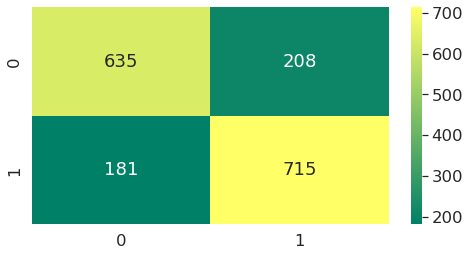

In [88]:
model_prediction(LogisticRegression())

The training Accuracy score of the KNeighborsClassifier() is: 83.56341673856772
The test Accuracy score of the KNeighborsClassifier() is: 75.15813686026452 
The precision score of the KNeighborsClassifier() is:  0.7703962703962703
The recall score of the KNeighborsClassifier() is:  0.7377232142857143
The F1 score of the KNeighborsClassifier() is:  0.7537058152793615


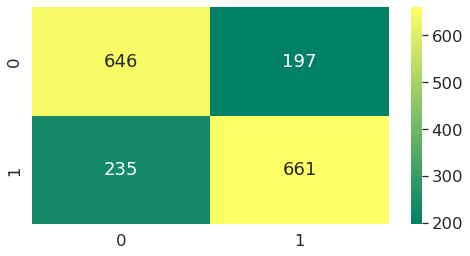

In [89]:
model_prediction(KNeighborsClassifier())

The training Accuracy score of the SVC() is: 81.55018694276676
The test Accuracy score of the SVC() is: 79.18343875790684 
The precision score of the SVC() is:  0.8
The recall score of the SVC() is:  0.7946428571428571
The F1 score of the SVC() is:  0.7973124300111982


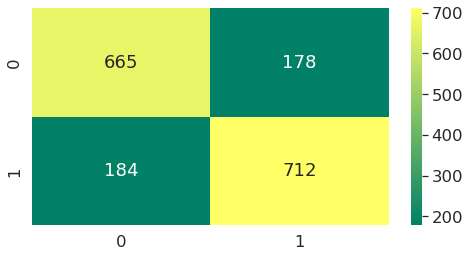

In [90]:
model_prediction(SVC())

The training Accuracy score of the GaussianNB() is: 74.00057520851308
The test Accuracy score of the GaussianNB() is: 72.3404255319149 
The precision score of the GaussianNB() is:  0.7854195323246217
The recall score of the GaussianNB() is:  0.6372767857142857
The F1 score of the GaussianNB() is:  0.7036352433764632


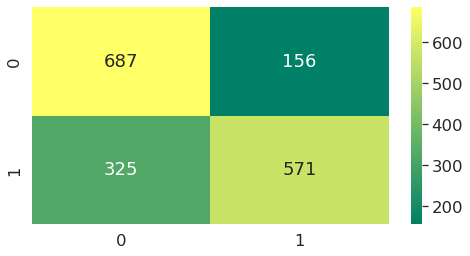

In [91]:
model_prediction(GaussianNB())

In [92]:
def model_prediction1(model):
    model.fit(X_train,y_train)
    X_train_pred=model.predict(X_train)
    X_test_pred=model.predict(X_test)
    a=accuracy_score(y_train,X_train_pred)*100
    b=accuracy_score(y_test,X_test_pred)*100
    training_score.append(a)
    test_score.append(b)
    print(f'The training Accuracy score of the {model} is: {a}')
    print(f'The test Accuracy score of the {model} is: {b} ')
    print(f'The precision score of the {model} is: ',precision_score(y_test,X_test_pred))
    print(f'The recall score of the {model} is: ',recall_score(y_test,X_test_pred))
    print(f'The F1 score of the {model} is: ',f1_score(y_test,X_test_pred))
    cm=confusion_matrix(y_test,X_test_pred)
    plt.figure(figsize=(8,4))
    sns.heatmap(cm,annot=True,fmt='g',cmap='summer')
    plt.show()

The training Accuracy score of the DecisionTreeClassifier() is: 98.53321829163072
The test Accuracy score of the DecisionTreeClassifier() is: 74.1230592294422 
The precision score of the DecisionTreeClassifier() is:  0.7476744186046511
The recall score of the DecisionTreeClassifier() is:  0.7340182648401826
The F1 score of the DecisionTreeClassifier() is:  0.7407834101382488


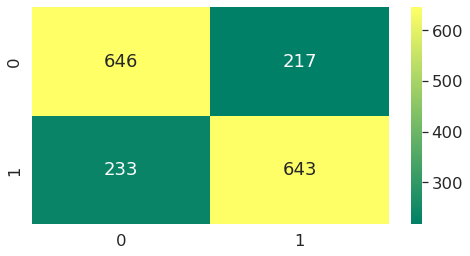

In [93]:
model_prediction1(DecisionTreeClassifier())

The training Accuracy score of the RandomForestClassifier() is: 98.53321829163072
The test Accuracy score of the RandomForestClassifier() is: 80.448533640023 
The precision score of the RandomForestClassifier() is:  0.8260340632603407
The recall score of the RandomForestClassifier() is:  0.7751141552511416
The F1 score of the RandomForestClassifier() is:  0.7997644287396938


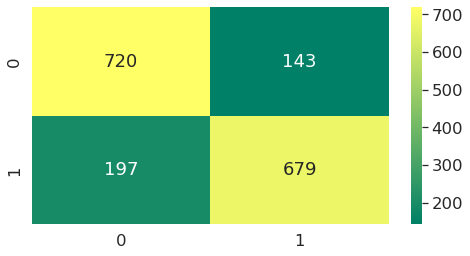

In [94]:
model_prediction1(RandomForestClassifier())

The training Accuracy score of the AdaBoostClassifier() is: 79.99712395743457
The test Accuracy score of the AdaBoostClassifier() is: 78.89591719378953 
The precision score of the AdaBoostClassifier() is:  0.7664921465968586
The recall score of the AdaBoostClassifier() is:  0.8356164383561644
The F1 score of the AdaBoostClassifier() is:  0.7995630802839977


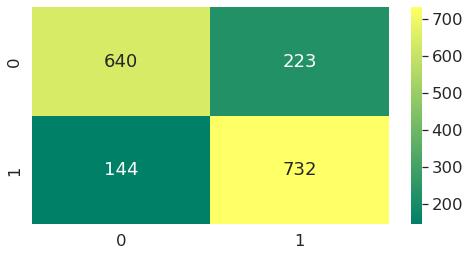

In [95]:
model_prediction1(AdaBoostClassifier())

The training Accuracy score of the GradientBoostingClassifier() is: 82.053494391717
The test Accuracy score of the GradientBoostingClassifier() is: 79.29844738355378 
The precision score of the GradientBoostingClassifier() is:  0.7721518987341772
The recall score of the GradientBoostingClassifier() is:  0.8356164383561644
The F1 score of the GradientBoostingClassifier() is:  0.8026315789473685


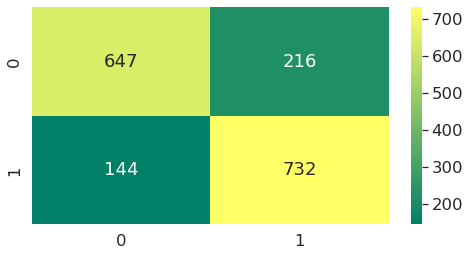

In [96]:
model_prediction1(GradientBoostingClassifier())

The training Accuracy score of the LGBMClassifier() is: 88.23698590739143
The test Accuracy score of the LGBMClassifier() is: 81.36860264519838 
The precision score of the LGBMClassifier() is:  0.8026315789473685
The recall score of the LGBMClassifier() is:  0.8356164383561644
The F1 score of the LGBMClassifier() is:  0.8187919463087249


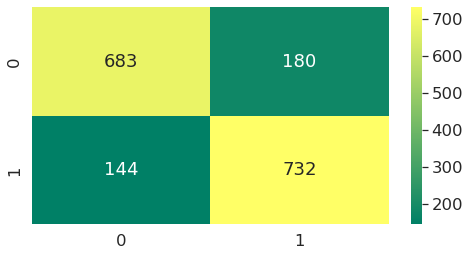

In [97]:
model_prediction1(LGBMClassifier())

The training Accuracy score of the XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...) is: 92.43600805291918
The test Accuracy score of the XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
      

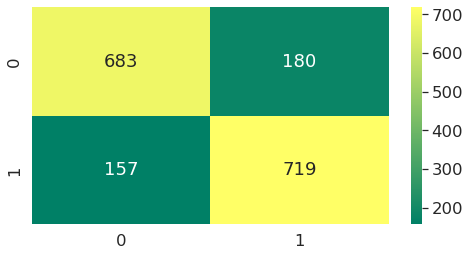

In [98]:
model_prediction1(XGBClassifier())

The training Accuracy score of the <catboost.core.CatBoostClassifier object at 0x7fc807398b90> is: 87.02904802991084
The test Accuracy score of the <catboost.core.CatBoostClassifier object at 0x7fc807398b90> is: 80.96607245543416 
The precision score of the <catboost.core.CatBoostClassifier object at 0x7fc807398b90> is:  0.8004410143329658
The recall score of the <catboost.core.CatBoostClassifier object at 0x7fc807398b90> is:  0.8287671232876712
The F1 score of the <catboost.core.CatBoostClassifier object at 0x7fc807398b90> is:  0.8143578238923164


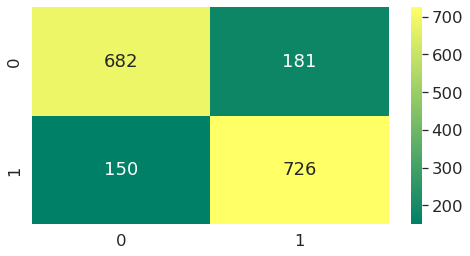

In [99]:
model_prediction1(CatBoostClassifier(verbose=False))

In [100]:
models = ["Logistic Regression","KNN","SVM","Naive Bayes","Decision Tree","Random Forest","Ada Boost",
          "Gradient Boost","LGBM","XGBoost","CatBoost"]

In [101]:
df=pd.DataFrame({'Algorithms':models,'Training Score':training_score,'Test Score':test_score})

In [102]:
df

,Algorithms,Training Score,Test Score
0,Logistic Regression,78.271498,77.630822
1,KNN,83.563417,75.158137
2,SVM,81.550187,79.183439
3,Naive Bayes,74.000575,72.340426
4,Decision Tree,98.533218,74.123059
5,Random Forest,98.533218,80.448534
6,Ada Boost,79.997124,78.895917
7,Gradient Boost,82.053494,79.298447
8,LGBM,88.236986,81.368603
9,XGBoost,92.436008,80.621047


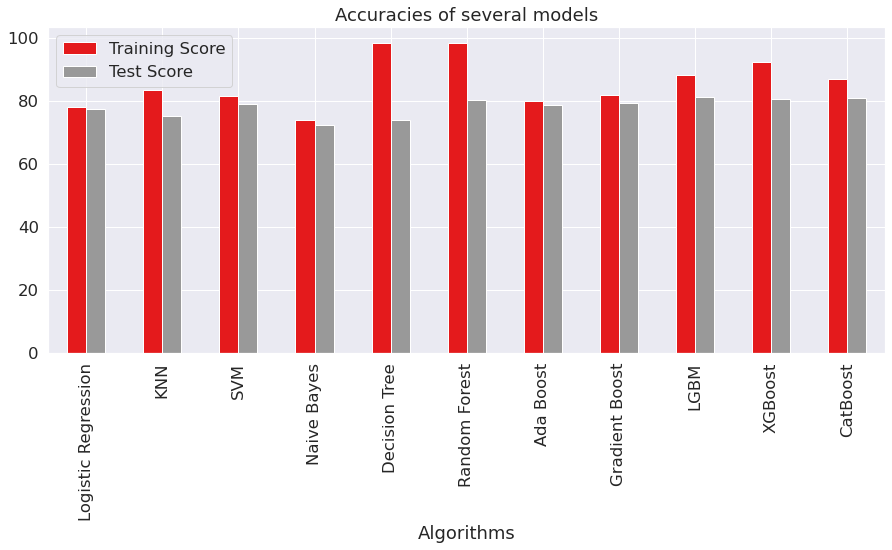

In [103]:
df.plot(x='Algorithms',y=['Training Score','Test Score'],figsize=(15,6),kind='bar',colormap='Set1',title='Accuracies of several models')
plt.show()

# Hyper Parameter Tunings for several algorithms LGBM Model

In [104]:
model1=LGBMClassifier()

In [105]:
parameters1={'n_estimators':[100,300,500,600,650],
            'learning_rate':[0.01,0.02,0.03],
            'random_state':[0,42,48,50],
            'num_leaves':[16,17,18]}

In [106]:
grid_search1=GridSearchCV(model1,parameters1,cv=5,n_jobs=1,verbose=1)

In [107]:
grid_search1.fit(X_train,y_train.values.ravel())

Fitting 5 folds for each of 180 candidates, totalling 900 fits


GridSearchCV(cv=5, estimator=LGBMClassifier(), n_jobs=1,
             param_grid={'learning_rate': [0.01, 0.02, 0.03],
                         'n_estimators': [100, 300, 500, 600, 650],
                         'num_leaves': [16, 17, 18],
                         'random_state': [0, 42, 48, 50]},
             verbose=1)

In [108]:
grid_search1.best_score_

0.8067300063615533

In [109]:
best_params1=grid_search1.best_params_

In [110]:
model1=LGBMClassifier(**best_params1)

In [111]:
model1.fit(X_train,y_train)

LGBMClassifier(learning_rate=0.03, n_estimators=300, num_leaves=17,
               random_state=0)

In [112]:
X_test_pred1=model1.predict(X_test)

In [113]:
X_test_pred1

array([0, 1, 0, ..., 1, 0, 1])

In [114]:
accuracy_score(y_test,X_test_pred1)

0.81196089706728

# Model 2 Catboost Classifier hyperparameter tuning

In [115]:
model2=CatBoostClassifier(verbose=False)

In [116]:
parameters2={'learning_rate':[0.01,0.03,0.05,0.06],
            'random_state':[0,42,54,46],
            'depth':[8,9,10],
            'iterations':[35,40,50]}

In [117]:
grid_search2=GridSearchCV(model2,parameters2,cv=5,n_jobs=1)

In [118]:
grid_search2.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x7fc807058fd0>,
             n_jobs=1,
             param_grid={'depth': [8, 9, 10], 'iterations': [35, 40, 50],
                         'learning_rate': [0.01, 0.03, 0.05, 0.06],
                         'random_state': [0, 42, 54, 46]})

In [119]:
grid_search2.best_score_

0.8038544807575938

In [120]:
params2=grid_search2.best_params_

In [121]:
model2=CatBoostClassifier(**params2,verbose=False)

In [122]:
model2.fit(X_train,y_train)

In [123]:
X_test_pred2=model2.predict(X_test)

In [124]:
accuracy_score(y_test,X_test_pred2)

0.7952846463484762

# Model 3: XGBoost Classifier

In [125]:
model3=XGBClassifier()

In [126]:
parameters3={'learning_rate':[0.01,0.03,0.05,0.06],
            'n_estimators':[50,100,150],
            'random_state':[0,42,50]}

In [127]:
grid_search3=GridSearchCV(model3,parameters3,cv=5,n_jobs=-1)

In [128]:
grid_search3.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...one,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
              

In [129]:
grid_search3.best_score_

0.8054348354529891

In [130]:
params3=grid_search3.best_params_
params3

{'learning_rate': 0.05, 'n_estimators': 150, 'random_state': 0}

In [131]:
model3=XGBClassifier(**params3)

In [132]:
model3.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=150,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [133]:
X_test_pred3=model3.predict(X_test)

In [134]:
accuracy_score(y_test,X_test_pred3)

0.81196089706728

# Model 4: Random Forest hyperparameters tuning

In [135]:
model4=RandomForestClassifier()

In [136]:
parameters4={'n_estimators':[100,200,300,400],
            'min_samples_split':[7,8,9],
            'max_depth':[10,11,12],
            'min_samples_leaf':[4,5,6]}

In [137]:
grid_search4=GridSearchCV(model4,parameters4,cv=5,n_jobs=-1)

In [138]:
grid_search4.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [10, 11, 12],
                         'min_samples_leaf': [4, 5, 6],
                         'min_samples_split': [7, 8, 9],
                         'n_estimators': [100, 200, 300, 400]})

In [139]:
grid_search4.best_score_

0.8015526328038935

In [140]:
params4=grid_search4.best_params_
params4

{'max_depth': 10,
 'min_samples_leaf': 5,
 'min_samples_split': 9,
 'n_estimators': 200}

In [141]:
model4=RandomForestClassifier(**params4)

In [142]:
model4.fit(X_train,y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=5, min_samples_split=9,
                       n_estimators=200)

In [143]:
X_test_pred4=model4.predict(X_test)

In [144]:
accuracy_score(y_test,X_test_pred4)

0.7964347326049454

In [145]:
stacking_model=StackingClassifier(estimators=[('LGBM',model1),
                                             ('CAT Boost',model2),
                                             ('XGBoost',model3),
                                             ('RandomForest',model4)])

In [146]:
stacking_model.fit(X_train,y_train)

StackingClassifier(estimators=[('LGBM',
                                LGBMClassifier(learning_rate=0.03,
                                               n_estimators=300, num_leaves=17,
                                               random_state=0)),
                               ('CAT Boost',
                                <catboost.core.CatBoostClassifier object at 0x7fc807058110>),
                               ('XGBoost',
                                XGBClassifier(base_score=0.5, booster='gbtree',
                                              callbacks=None,
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=1,
                                              early_stopping_rounds=None,
                                              en...
                                              learning_rate=0.05, max_bin=256,
                    

In [147]:
X_train_pred5=stacking_model.predict(X_train)
X_test_pred5=stacking_model.predict(X_test)

In [148]:
print('The training accuracy is: ',accuracy_score(y_train,X_train_pred5))
print('The test accuracy is: ',accuracy_score(y_test,X_test_pred5))

The training accuracy is:  0.8455565142364107
The test accuracy is:  0.8102357676825762


In [149]:
pred=stacking_model.predict(test)

In [150]:
len(test)

4277

In [151]:
passenger_df.head()

0    0013_01
1    0018_01
2    0019_01
3    0021_01
4    0023_01
Name: PassengerId, dtype: object

In [152]:
passenger_df=pd.DataFrame(passenger_df)

In [153]:
len(passenger_df)

4277

In [154]:
len(pred)

4277

In [155]:
passenger_df.head()

,PassengerId
0,0013_01
1,0018_01
2,0019_01
3,0021_01
4,0023_01


In [156]:
passenger_df['Transported']=pred

In [157]:
passenger_df['Transported'].replace({1:True,0:False},inplace=True)

In [158]:
passenger_df.to_csv('spaceship_prediction_project.csv',index=False)